## Testing the PIN Variable Optical Attenuators

### 1 ) Perform a wavelength sweep and save the data as a sweep object

objective : make a function that can be used to do wavelength sweeps with the agilent Lightwave measurement System. 

Note : The driver for this instrument **hp816x_32.dll** only works with 32 bits anaconda (on python 2 for whatever reason).
Note2 : If Error 0 : no error, the laser power needs to be set to -10 dBm.

In [32]:
from Instruments import hp816x_instr
from data.sweepobj import sweepobj
from data.wvlsweep import wvlsweep
import os
%matplotlib inline

Disconnected from the laser
The mainframe is: HP8164A
Connected to the laser
Saving wavelength sweep to Z:\shi_group\lab\measures\SiEPIC_Passives_Workshop_2017\Simon\ULPythonLab\april30_data\1702PH_193nm_die01\ ...
Total number of datapoints: 4001
Stitch number: 1
Sweeping from 1530.0 nm to 1570.0 nm


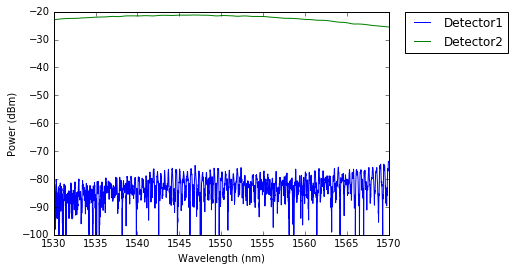

Saving the data to Z:\shi_group\lab\measures\SiEPIC_Passives_Workshop_2017\Simon\ULPythonLab\april30_data\1702PH_193nm_die01\Align4 ...


In [36]:
data_dir = os.getcwd() + "\\april30_data\\1702PH_193nm_die01\\"
LMS = hp816x_instr.hp816x()
LMS.connect('GPIB0::20::INSTR')
print("Saving wavelength sweep to " + data_dir + " ...")
wvlsweep(LMS, data_dir, wvl_start=1530e-9, wvl_stop=1570e-9, wvl_step=0.01e-9, plot_det1 = True, plot_det2 = True, filename="Align4")
LMS.setTLSState("off")

Try opening the file afterwards.

In [ ]:
%matplotlib qt
data_dir = os.getcwd() + "\\april30_data\\1702PH_193nm_die01\\"
swobj = sweepobj(data_dir + "RT3")
swobj.xlims             = [1530, 1570]
swobj.ylims             = [-85,-20]
swobj.show()

It works. It can be used to acquire the data.

### 2) Perform a voltage sweep for the VOA and measure the wavelength dependant attenuation as well as the voltage and the current applied to the PIN VOA

Measure the IV curve of the PIN junction.

In [ ]:
import datetime

#For branch 1 of the VOA

# TODO : save the voltage and the current in the sweepobject datafile as an attribute
# TODO : Make this a function that can be repeated for the 2 branches of each of the 5 VOAs
# TODO : make calibration easy
# TODO : perform the measurements for all VOAs and do the results formatting accordingly (V 3dB, Length for v 3dB , ...)
# TODO : Format the datafiles into one single file for simplicity (facultative)

# INFO
#device    = "VOA1"
#chip      = "1702PH"
#Litho     = "248 nm"
#die       = 1
#date      = datetime.datetime.now()
#VOAlength = 500e-6
wvl_start = 1530e-9
wvl_stop  = 1570e-9
wvl_step  = 0.1e-9

# VOA sweep
PINVOA_voltage, PINVOA_current = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], []
data_dir = os.getcwd() + "\\april30_data\\1702PH_193nm_die01\\VOA5\\waveguide2\\"
f = open(data_dir + "datatable.txt", "w+")
f.write("V [V]" + "     " + "I [mA]\n")

# Tunable laser source
LMS = hp816x_instr.hp816x()
LMS.connect('GPIB0::20::INSTR')

for V in PINVOA_voltage:
    raw_input("Set the voltage applied to the VOA to " + str(V) + " V. Press any key to continue...")
    I = raw_input("What is the current measured?")
    f.write(str(V) + "     " + str(I) + "\n")
    PINVOA_current.append(I)
    wvlsweep(LMS, data_dir, wvl_start, wvl_stop, wvl_step, True, True, str(V))
    
LMS.disconnect()
f.close()

### Plot the data

1) Plot the transmission spectrum of the VOA for the different applied voltage. Change the data_dir variable in order to point to thr right directory.

In [ ]:
# TODO : Order the plots in ascending voltage or current.

# To plot all the data in a single directory (data in pickle files)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
data_dir = os.getcwd() + "\\april30_data\\1702PH_193nm_die01\\VOA5\\waveguide2\\"


plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
ax.tick_params(which='major', direction='inout', length=8, width=2, colors='k',
                       labelsize=18)
ax.tick_params(which='minor', direction='in', length=4, width=1, colors='k',
                       labelsize=18)

for file in os.listdir(data_dir)[::-1]:
    if file.endswith(".pickle"):
        s = sweepobj(data_dir + os.path.splitext(file)[0])
        plt.plot(s.wavelength*1e9,s.detector_1, label= "V = " + os.path.splitext(file)[0] + " V")
        plt.xlabel("Wavelength [nm]", fontsize=18)
        plt.ylabel("Transmission [dB]", fontsize=18)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### 3) Test the photodetectors using the Keithley SMU

In [1]:
# Connect the instruments

from Instruments import hp816x_instr
from Instruments.Keithley_2612B import Keithley_2612B
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Setup the laser
LMS = hp816x_instr.hp816x()
LMS.connect('GPIB0::20::INSTR')
LMS.setTLSOutput('lowsse')
LMS.setTLSWavelength(1550e-9)

# Setup the current meter
PD = Keithley_2612B(0,25,'a')
PD.connect()

The mainframe is: HP8164A
Connected to the laser
Connected to the instrument.


### Measure the responsivity for a specific wavelength. 

The responsivity is given by

$$R=\frac{P}{I}$$

Considering the insertion loss of the input grating coupler to be roughly 6 dB. Doesn't matter for responsivity, only for the dark current.

In [11]:
def measure_responsivity(LMS, PD, wavelength, power_values, plot_resp=False):
    """
    Sweep the laser power and measure the responsivity for a specific wavelength
    """
    IL_GC = 6  # Insertion loss of the input grating coupler [dB]
    
    LMS.setTLSWavelength(wavelength)
    current_values = []
    for P in power_values:
        time.sleep(0.1)
        LMS.setTLSPower(P)
        current_values.append(PD.measure_current()[0])
        
    if plot_resp:
        plt.plot(1e-3*10**((power_values-IL_GC)/10), current_values)
        plt.xlabel('Optical Power [W]')
        plt.ylabel('Photocurrent [A]')
        plt.show()
    
    return np.mean(np.diff(np.asarray(current_values))/np.diff(1e-3*10**((power_values-IL_GC)/10)))

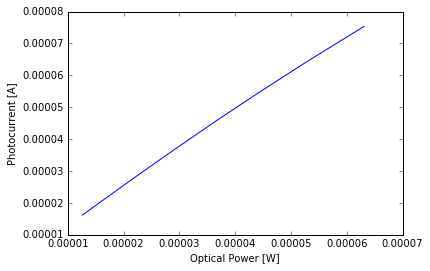

1.1991323495


In [13]:
PD.source_voltage(0)
PD.output_on()
LMS.setTLSState("on")
R = measure_responsivity(LMS, PD, 1550e-9, np.linspace(-6,-13,10), True)
LMS.setTLSState("off")

print(R)

### Measure the spectral responsivity

Measure the responsivity [A/W] for different wavelengths.

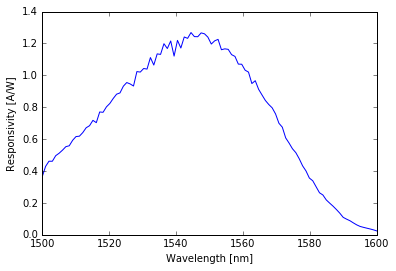

NameError: name 'os' is not defined

In [14]:
power_values, wavelength_values, responsivity = np.linspace(-10,-13,10), np.linspace(1500e-9,1600e-9,100), []
LMS.setTLSState("on")
for wavelength in wavelength_values:
    responsivity.append(measure_responsivity(LMS, PD, wavelength, power_values))
LMS.setTLSState("off")

# Plot the responsivity
plt.plot(wavelength_values*1e9, responsivity)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Responsivity [A/W]')
plt.show()

# Save the data in a text file
data_dir = os.getcwd() + "\\april30_data\\1702PH_193nm_die01\\"
np.savetxt(data_dir + 'PD2_spectral_responsivity.txt', (wavelength_values, np.asarray(responsivity)))

In [15]:
import os
data_dir = os.getcwd() + "\\april30_data\\1702PH_193nm_die01\\"
np.savetxt(data_dir + 'PD2_spectral_responsivity.txt', (wavelength_values, np.asarray(responsivity)))

### Measure the dark current

Measure the IV curve of the photodetector for various applied power and bias

In [ ]:
voltage_values, current_values = np.linspace(-5,4,10), []
PD.output_on()
for V in voltage_values:
    PD.source_voltage(V)
    current_values.append(PD.measure_current()[0])
PD.output_off()   

plt.plot(voltage_values, current_values)
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.show()

In [ ]:
voltage_values, current_values = np.linspace(4,-5,10), []
PD.output_on()
for V in voltage_values:
    PD.source_voltage(V)
    current_values.append(-1*PD.measure_current()[0])
PD.output_off()   

plt.plot(-1*voltage_values, current_values)
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.show()

In [30]:
%matplotlib qt
# Measure the IV curve for different bias and optical power applied
#data_dir = os.getcwd() + "\\april30_data\\1702PH_193nm_die01\\PD2\\"
power_values = np.linspace(-6,-13,3)
voltage_values = np.linspace(-10,10,20)


LMS.setTLSState("on")
for P in power_values:
    LMS.setTLSPower(P)
    PD.output_on()
    current_values = []
    for V in voltage_values:
        PD.source_voltage(V)
        current_values.append(-1*PD.measure_current()[0])
    PD.output_off()   
    plt.plot(-1*voltage_values, current_values, label=str(P)+" dBm")
    #np.savetxt(data_dir + str(P) + '.txt', (-1*voltage_values, np.asarray(current_values)))
LMS.setTLSState("off")

plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.show()

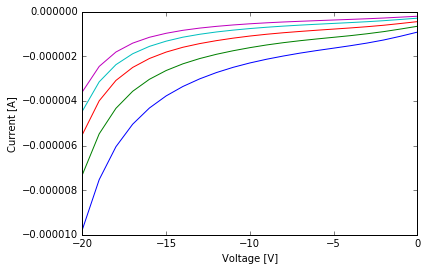

In [28]:
%matplotlib inline
power_values = np.linspace(-6,-13,5)
for P in power_values:
    V,I = np.loadtxt(data_dir + str(P) + '.txt')
    plt.plot(V,I, label=str(P)+" dBm")
LMS.setTLSState("off")

plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.show()